# CoaT small parallel

In [38]:
CURRENT_FOLD = 3

# imports

In [1]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torch.cuda.amp as amp
is_amp = True

# data

In [2]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

# model testing

In [3]:
# from model_coat_daformer import *
# from coat import *

In [4]:
# encoder = coat_parallel_small
# decoder = daformer_conv3x3

# model = Net(encoder=encoder, decoder=decoder, n_classes=3)

In [5]:
# sample_input = torch.randn(1, 3, 768, 768)

In [6]:
# sample_mask = torch.tensor([[0, 1], [1, 0]], dtype=torch.float).repeat(8, 8)

In [7]:
# plt.imshow(sample_mask)
# plt.show()

In [8]:
# sample_mask = sample_mask.unsqueeze(0).unsqueeze(1)

In [9]:
# sample_output = model.forward_mae({'image': sample_input, 
#                                    'mae_mask': sample_mask})

In [10]:
# sample_output.keys()

In [11]:
# for key in sample_output.keys():
#     print(key, sample_output[key].shape)

## data 768

In [12]:
TRAIN_CSV = './../../data/train.csv'
TEST_CSV = './../../data/test.csv'
TRAIN_IMAGES_DIR = './../data_ready/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 256 # размер патча


In [13]:
train_df = pd.read_csv(TRAIN_CSV)

In [14]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [15]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [16]:
train_df = train_df[train_df['organ'].isin(['largeintestine'])]

In [17]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
6,10651,largeintestine,HPA,3000,3000,0.4,4,1240229 12 1243227 15 1246223 26 1249221 29 12...,83.0,Male,2.0
9,10892,largeintestine,HPA,3000,3000,0.4,4,523786 3 526784 8 529782 8 532778 9 535642 25 ...,79.0,Female,2.0
20,11662,largeintestine,HPA,3000,3000,0.4,4,673655 29 676649 41 679645 47 682638 59 685636...,84.0,Female,0.0
21,1168,largeintestine,HPA,3000,3000,0.4,4,652348 27 655344 35 658310 79 661305 93 664303...,84.0,Male,2.0
23,11890,largeintestine,HPA,3000,3000,0.4,4,1297230 32 1300222 46 1303215 60 1306213 63 13...,79.0,Female,4.0


In [18]:
train_df.shape

(58, 11)

In [21]:
def make_256_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('train_images_', 'train_masks_')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [55]:
len(glob('./../data_ready/*.png'))

400

In [54]:
for fname in glob('./../data_ready/*.png'):
    if fname in list(train_df_256['image']):
        print(fname)
    else:
#         pass
        os.remove(fname)

./../data_ready/12471_00005.png
./../data_ready/1168_00019.png
./../data_ready/15842_00002.png
./../data_ready/13507_00007.png
./../data_ready/12174_00018.png
./../data_ready/11662_00025.png
./../data_ready/15499_00003.png
./../data_ready/12471_00023.png
./../data_ready/16728_00025.png
./../data_ready/12471_00011.png
./../data_ready/15842_00003.png
./../data_ready/14674_00004.png
./../data_ready/1168_00000.png
./../data_ready/11890_00004.png
./../data_ready/11890_00005.png
./../data_ready/13396_00000.png
./../data_ready/15842_00007.png
./../data_ready/1168_00020.png
./../data_ready/13396_00015.png
./../data_ready/13507_00014.png
./../data_ready/16728_00008.png
./../data_ready/16728_00014.png
./../data_ready/15842_00017.png
./../data_ready/15842_00008.png
./../data_ready/13396_00006.png
./../data_ready/15499_00023.png
./../data_ready/1168_00006.png
./../data_ready/12174_00013.png
./../data_ready/10651_00019.png
./../data_ready/15842_00025.png
./../data_ready/12471_00025.png
./../data_re

./../data_ready/10892_00029.png
./../data_ready/12471_00027.png
./../data_ready/12174_00021.png
./../data_ready/14183_00005.png
./../data_ready/14183_00024.png
./../data_ready/15842_00001.png
./../data_ready/12471_00022.png
./../data_ready/12471_00007.png
./../data_ready/12174_00004.png
./../data_ready/13507_00027.png
./../data_ready/14183_00002.png
./../data_ready/15842_00023.png
./../data_ready/11890_00017.png
./../data_ready/13507_00001.png
./../data_ready/11662_00009.png
./../data_ready/13507_00008.png
./../data_ready/11662_00000.png
./../data_ready/12174_00005.png
./../data_ready/12174_00008.png
./../data_ready/12174_00027.png
./../data_ready/14674_00008.png
./../data_ready/10892_00030.png
./../data_ready/11890_00020.png
./../data_ready/15499_00008.png
./../data_ready/12174_00025.png
./../data_ready/13507_00028.png
./../data_ready/13396_00009.png
./../data_ready/14183_00022.png
./../data_ready/14674_00020.png
./../data_ready/14183_00014.png
./../data_ready/11662_00020.png
./../dat

In [22]:
train_df_256 = make_256_dataset(train_df).iloc[:400]
print(train_df_256.shape)
train_df_256.head()

(400, 6)


,fold,id,image,mask,organ,pixel_size
0,2.0,10651,./../data_ready/10651_00019.png,./../data_ready/10651_00019.png,largeintestine,0.4
1,2.0,10651,./../data_ready/10651_00021.png,./../data_ready/10651_00021.png,largeintestine,0.4
2,2.0,10651,./../data_ready/10651_00000.png,./../data_ready/10651_00000.png,largeintestine,0.4
3,2.0,10651,./../data_ready/10651_00024.png,./../data_ready/10651_00024.png,largeintestine,0.4
4,2.0,10651,./../data_ready/10651_00011.png,./../data_ready/10651_00011.png,largeintestine,0.4


In [26]:
train_df_256.iloc[0]['image']

'./../data_ready/10651_00019.png'

In [27]:
train_df_256.iloc[0]['mask']

'./../data_ready/10651_00019.png'

In [28]:
train_df_256.iloc[0]['id']

10651

In [29]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [30]:
mean = np.array([0.0, 0.0, 0.0])
std = np.array([1.0, 1.0, 1.0])

In [31]:
train_transform= A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.HueSaturationValue(p=0.25),
#     A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(-0.1, 0.7),rotate_limit=90, p=0.5),
#     A.ElasticTransform(p=0.2, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#     A.ElasticTransform(p=0.5, alpha=90, sigma=120*0.7, alpha_affine=120 * 0.8),
    
#     A.GridDistortion(p=0.25),
#     A.Blur(blur_limit=7, p=0.1),
#     A.GaussNoise(var_limit=(20, 100), p=0.4),
#     A.ChannelDropout(p=0.05),
#     A.RandomGamma(p=0.1),
#     A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [32]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [33]:
def gen_random_mask(shape, ratio_keep=0.6):
    mask = np.ones(shape[0] * shape[1], dtype=np.float32)
    N = len(mask)
    mask[:int(N * ratio_keep)] = 0.0
    np.random.shuffle(mask)
    mask = mask.reshape(shape[0], shape[1])
    return mask

In [43]:
class HubmapDatasetMAE256(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mae_mask = gen_random_mask((32, 32), ratio_keep=0.3)
        mae_mask = cv.resize(mae_mask, dsize=(image.shape[0]//4, image.shape[1]//4), interpolation=cv.INTER_NEAREST)
        mae_mask = torch.tensor(mae_mask)

        data = {
            'image': image,
            'mae_mask': mae_mask
        }
        upd_data = self.transform(image=data['image'])

        data.update(upd_data)
        return data

In [44]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [45]:
train_dataset = HubmapDatasetMAE256(train_df_256[train_df_256['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDatasetMAE256(train_df_256[train_df_256['fold'] == CURRENT_FOLD], val_transform)

IMAGE
torch.Size([3, 256, 256])
image values:  0.10588236153125763 0.960784375667572


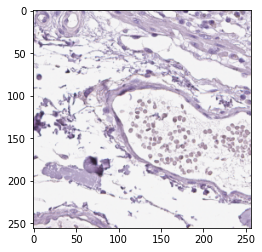

MASK
torch.Size([64, 64])
mask values:  tensor(0.) tensor(1.)


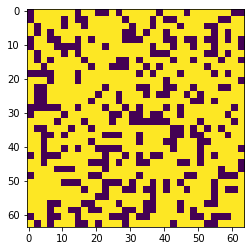

In [46]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mae_mask'].shape)
print('mask values: ', sample['mae_mask'].min(), sample['mae_mask'].max())
plt.imshow(sample['mae_mask'])
plt.show()

In [47]:
BATCH_SIZE = 4

In [48]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

IMAGE
torch.Size([3, 256, 256])
image values:  0.0 0.960784375667572


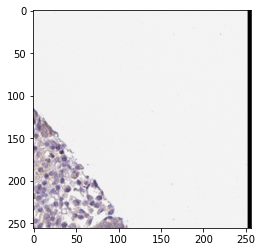

MASK
torch.Size([64, 64])
mask values:  tensor(0.) tensor(1.)


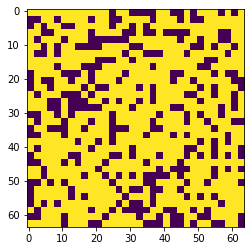

In [49]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mae_mask'].shape)
print('mask values: ', sample['mae_mask'].min(), sample['mae_mask'].max())
plt.imshow(sample['mae_mask'])
plt.show()

# model

In [50]:
!nvidia-smi

Sat Sep  3 12:49:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   44C    P0    40W / 300W |     57MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   45C    P0    54W / 300W |   1905MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [38]:
device = 'cuda:1'
DEVICE = device

In [39]:
encoder = coat_parallel_small
decoder = daformer_conv3x3

model = Net(encoder=encoder, decoder=decoder, n_classes=3).to(device)

In [40]:
model.encoder.load_state_dict(torch.load('./../coat-first-try/coat_small_7479cf9b.pth')['model'], strict=False)

_IncompatibleKeys(missing_keys=['mask_token'], unexpected_keys=['norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias', 'norm4.weight', 'norm4.bias', 'aggregate.weight', 'aggregate.bias', 'head.weight', 'head.bias'])

In [41]:
model.load_state_dict(torch.load('./checkpoint_pretrain_fold_3/last_dice_UNK.pt'))

<All keys matched successfully>

# lr schedule

In [42]:
def lr_function(step):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 5e-4    #A
    rampup_epochs = 100; sustain_epochs = 200; exp_decay = 1    #B
 
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:    #C
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:    #D
            lr = max_lr
        else:    #E
            lr = max((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs)* (0.8+0.01*np.sin(epoch / 100)), 0) + min_lr
        return lr
 
    return lr(step, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay) / max_lr

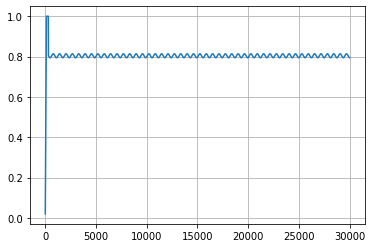

In [43]:
xxx = []
for i in range(30000):
    xxx.append(lr_function(i))
    
plt.plot(xxx)
plt.grid()
plt.show()

# Criterions

In [44]:
import segmentation_models_pytorch as smp

In [45]:
l1loss = nn.L1Loss()
l2loss = nn.MSELoss()
def criterion(pred, true):
    return  0.98 * l1loss(pred, true) + 0.02 * l2loss(pred, true)

# validation code

In [46]:
import monai
from monai.utils.enums import BlendMode, PytorchPadMode
from monai.inferers import sliding_window_inference

In [47]:
class Predictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        _, _, H, W = x.shape
        H = int(H)
        W = int(W)
        
        mae_mask = gen_random_mask((32, 32), ratio_keep=0.3)
        mae_mask = cv.resize(mae_mask, dsize=(H//4, W//4), interpolation=cv.INTER_NEAREST)
        mae_mask = torch.tensor(mae_mask).unsqueeze(0).unsqueeze(1).to(device)
        
        
        out = self.model.forward_mae({'image' : x, 'mae_mask': mae_mask})
#         print(out.keys())
#         img = F.interpolate(out['logits'], size=(512, 512))
        return out['logits']

In [48]:
def infer_id(predictor, id: str, organ: str, pixel_size=0.4):
    
    image = cv.imread('./../data/train_images/{}.tiff'.format(id))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    scale_factor = 0.5 * (pixel_size / 0.4)
    image = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
    
    masks = []
        
    image_tensor = val_transform(image=image)['image']

    image_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        infer_result = sliding_window_inference(
            image_tensor, roi_size=(768, 768), sw_batch_size=2, predictor=predictor, 
            overlap=0.5, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
            padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
        )

    
    pr_img = infer_result.detach().cpu().numpy()[0].transpose((1, 2, 0)).astype(np.float32)
    
#     print(pr_img.shape)
        
    pr_img = cv.resize(pr_img, dsize=image.shape[:2], interpolation=cv.INTER_NEAREST)
    
    return pr_img, image.astype(np.float32) / 255.0

In [49]:
def validate(val_df, model):
    predictor = Predictor(model)
    
    mae_losses = []
    
    by_organ_mae_losses = {key:[] for key in ORGAN2ID.keys()}
    for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
        id = row['id']
        organ = row['organ']
        pixel_size = row['pixel_size']
        pred_img, gt_img = infer_id(predictor, id, organ=organ, pixel_size=pixel_size)
        mae_loss = np.abs(pred_img - gt_img).mean()
        mae_losses.append(mae_loss)
        by_organ_mae_losses[organ].append(mae_loss)
    new_record = dict()
    new_record['dices'] = mae_losses
    new_record['by_organ'] = by_organ_mae_losses
    return new_record

In [50]:
val_df_id = train_df[train_df['fold'] == CURRENT_FOLD]

# training

In [51]:
learning_rate = 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [52]:
scaler = amp.GradScaler(enabled = is_amp)

In [53]:
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_function)

In [54]:
train_loss = []
accuracy = [] 
lr_hist = []

In [55]:
PTH = './checkpoint_pretrain_fold_{}'.format(CURRENT_FOLD)

In [56]:
Path(PTH).mkdir(parents=True, exist_ok=True)

In [57]:
logfile = open(PTH + '/log.train.txt', mode='a')
logfile.write('\n--- [START %s] %s\n\n' % ('coat-small pretrain', '-' * 64))

99

In [58]:
def log(string):
    print(string)
    logfile.write(string + '\n')

In [59]:
N_EPOCHS = 450
global_it = 0
VIRTUAL_BATCH_SIZE = 4

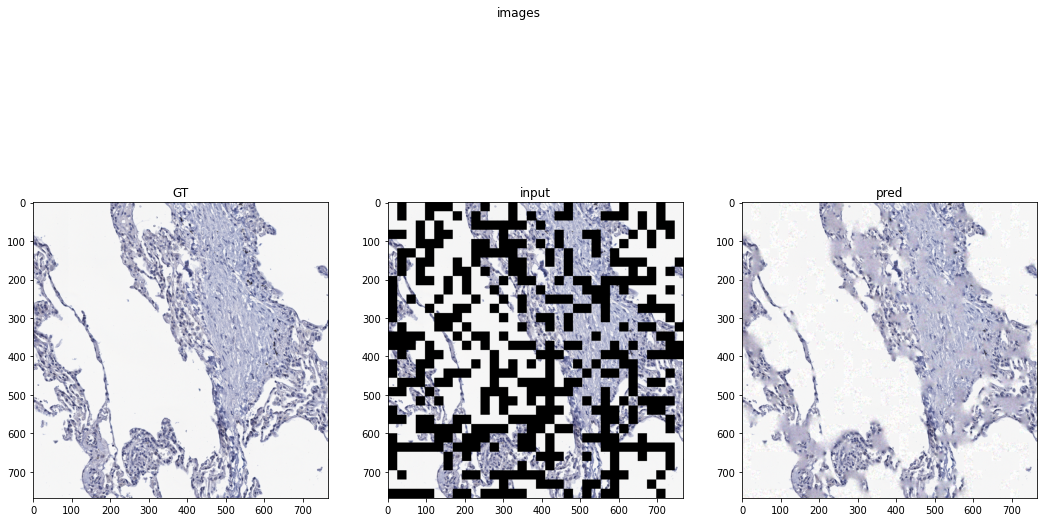

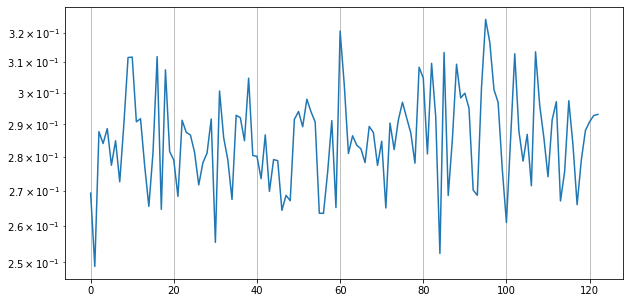

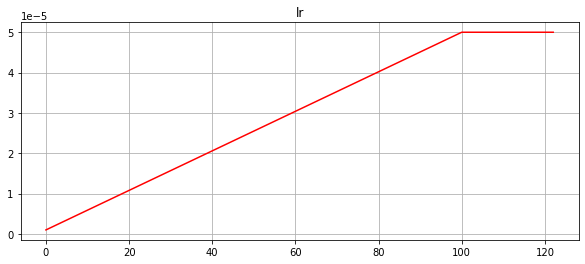

==> Epoch 4 (002/088) | loss: 0.33651
==> Epoch 4 (018/088) | loss: 0.22075
==> Epoch 4 (034/088) | loss: 0.27247
==> Epoch 4 (050/088) | loss: 0.29625
==> Epoch 4 (066/088) | loss: 0.30150
==> Epoch 4 (082/088) | loss: 0.21799
==> Epoch 5 (010/088) | loss: 0.29147
==> Epoch 5 (026/088) | loss: 0.33000
==> Epoch 5 (042/088) | loss: 0.26856
==> Epoch 5 (058/088) | loss: 0.35726
==> Epoch 5 (074/088) | loss: 0.22870


In [ ]:
for epoch in range(0, N_EPOCHS):
    criterion_image = criterion
    
    model.train()
    
    batch_train_loss = []
    
    for iteration, batch in enumerate(loader_train):
        global_it += 1
#         print(batch['mae_mask'].shape)
        batch['image'] = batch['image'].half().to(device)
        batch['mae_mask'] = batch['mae_mask'].unsqueeze(1).to(device, dtype=torch.float32)

        
        
        with amp.autocast(enabled = is_amp):
            output = model.forward_mae(batch)
            pred_image = output['logits']
            
#             inter_image = F.interpolate(batch['image'], size=pred_image.shape[2:4])
            loss0 = output['loss']# criterion_image(pred_image, batch['image'])
    
#             loss_s_aux1  = criterion_image  (output['aux_serial_1'],  batch['mask']).mean()
            loss_s_aux2  = criterion_image  (output['aux_serial_2'],   batch['image']).mean()
#             loss_s_aux3  = criterion_image  (output['aux_serial_3'],  batch['mask']).mean()
        
            loss_p_aux1  = criterion_image  (output['aux_parallel_1'],  batch['image']).mean()
            loss_p_aux2  = criterion_image  (output['aux_parallel_2'],  batch['image']).mean()
#             loss_p_aux3  = criterion_image  (output['aux_parallel_2'],  batch['mask']).mean()
            

        optimizer.zero_grad()
        loss = loss0 + 0.05 * loss_s_aux2 + 0.05 * loss_p_aux2 + 0.05 * loss_p_aux1
        
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            scaler.step(optimizer)
        scaler.update()

        
        # ---
                 
        batch_train_loss.append(loss.item())          
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            train_loss.append(np.mean(batch_train_loss))
            batch_train_loss = []
            lr_hist.append(optimizer.param_groups[0]['lr'])
            scheduler_warmup.step()
                    
        if global_it % (VIRTUAL_BATCH_SIZE * 2) == 0:
            log('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch, iteration, len(loader_train), loss.item()))


#         if iteration % (VIRTUAL_BATCH_SIZE * 10) == 0:
        if iteration == 0 and epoch % 2 == 0:
            
            clear_output()
            
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10))
            fig.suptitle('images')
            sample = batch['image'][0].detach().cpu().numpy().transpose((1, 2, 0)).astype(np.float32)
            ax1.imshow(sample)
            ax1.set_title('GT')
            mask_rs = cv.resize(batch['mae_mask'][0].detach().cpu().numpy().transpose((1, 2, 0)), None, fx=4, fy=4, interpolation=cv.INTER_NEAREST)
            ax2.imshow(sample * (1 - mask_rs)[:, :, None])
            ax2.set_title('input')
            ax3.imshow(
                np.clip(
                    sample * (1 - mask_rs)[:, :, None] + 
                    mask_rs[:, :, None] * pred_image[0].detach().cpu().numpy().transpose((1, 2, 0)),
                        #np.array([[[0.229, 0.224, 0.225]]]) + np.array([[[0.485, 0.456, 0.406]]]),
                    0.0, 
                    1.0).astype(np.float32)
            )
            ax3.set_title('pred')
            
            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
               
    # val -------------------------------
    if epoch % 10 == 0:
        log('Eval')
        model.eval()

        with torch.no_grad():
            val_res = validate(val_df_id, model)
            val_dice = np.mean(val_res['dices'])
            log('DICE: {}'.format(val_dice))
            for key, value in val_res['by_organ'].items():
                log('{:20}: {:6.5f}'.format(key, np.mean(value)))

            torch.save(model.state_dict(), os.path.join(
                PTH, 
                'coat-small_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
            )) 

            logfile.flush()
    

In [ ]:
# aux_parallel_0 torch.Size([1, 3, 768, 768])
# aux_parallel_1 torch.Size([1, 3, 768, 768])
# aux_parallel_2 torch.Size([1, 3, 768, 768])
# aux_parallel_3 torch.Size([1, 3, 768, 768])
# aux_serial_0 torch.Size([1, 3, 768, 768])
# aux_serial_1 torch.Size([1, 3, 768, 768])
# aux_serial_2 torch.Size([1, 3, 768, 768])
# aux_serial_3 torch.Size([1, 3, 768, 768])
# logits torch.Size([1, 3, 768, 768])

In [ ]:
# log('Eval')
# model.eval()

# with torch.no_grad():
#     val_res = validate(val_df_id, model)
#     val_dice = np.mean(val_res['dices'])
#     log('DICE: {}'.format(val_dice))
#     for key, value in val_res['by_organ'].items():
#         log('{:20}: {:6.5f}'.format(key, np.mean(value)))

#     torch.save(model.state_dict(), os.path.join(
#         PTH, 
#         'coat-small_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
#     )) 

#     logfile.flush()

In [ ]:
# torch.save(model.state_dict(), os.path.join(
#         PTH, 
#         'last_dice_UNK.pt'.format(epoch)
#     )) 

In [ ]:
# model.encoder.parallel_blocks[-5]